# Bent waveguides (layout and simulation)

Step by step process:
1. Draw a bent waveguide and save it in a .gds file.
2. Load the bent waveguide using Meep.
3. Setup simulation environment.
4. Simulate FDTD and visualize results.
5. Compute loss and reflection of the bend.

In [1]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# Debug info
print("Meep version:", mp.__version__)

Using MPI version 3.1, 1 processes
Meep version: 1.12.0


In [2]:
import pya
import numpy as np

SIM_CELL = pya.LayerInfo(0, 0)
Si = pya.LayerInfo(1, 0)
MEEP_SOURCE1 = pya.LayerInfo(10, 0)
MEEP_PORT1 = pya.LayerInfo(20, 0)
MEEP_PORT2 = pya.LayerInfo(21, 0)

## Simulation Parameters

In [3]:
ring_radius = 8 # um
ring_width = 0.5 # um
pml_width = 1.0 # um
straight_wg_length = pml_width + 0.2 # um

# Simulation resolution
res = 100        # pixels/μm

## Step 1. Drawing a bent waveguide and saving into a temporary .gds file

In [4]:
from zeropdk.layout import layout_arc, layout_waveguide, layout_path, layout_box
from tempfile import NamedTemporaryFile

# Create a temporary filename
temp_file = NamedTemporaryFile(delete=False, suffix='.gds')
filename = temp_file.name

# Clean existing file
!rm {filename}

# Instantiate a layout and a top cell
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

# Unit vectors
ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

# Draw circular bend
layout_arc(TOP, Si, - ring_radius*ey, ring_radius, ring_width, 0, np.pi/2)

# Extend the bend to avoid discontinuities
layout_waveguide(TOP, Si, [0*ex, - straight_wg_length*ex], ring_width)
layout_waveguide(TOP, Si, [-1*ring_radius*ey + ring_radius*ex, 
                           -straight_wg_length * ey - ring_radius*ey + ring_radius*ex], ring_width)

# Add the ports as 0-width paths
port_size = ring_width * 4.0

# Source port
layout_path(TOP, MEEP_SOURCE1, [-port_size/2*ey - 0.2*ex, port_size/2*ey - 0.2*ex], 0)
# Input port (immediately at the start of the bend)
layout_path(TOP, MEEP_PORT1,   [-port_size/2*ey, port_size/2*ey], 0)
# Output port (immediately at the end of the bend)
layout_path(TOP, MEEP_PORT2,   [-1*ring_radius*ey + ring_radius*ex - port_size/2*ex, 
                               -1*ring_radius*ey + ring_radius*ex + port_size/2*ex], 0)

# Draw simulation region
layout_box(TOP, SIM_CELL, 
           -1.0*ring_radius*ey - straight_wg_length * (ex + ey), # Bottom left point 
            1.0*ring_radius*ex + (straight_wg_length + port_size / 2) * (ex + ey),  # Top right point
           ex)

# Write to file
layout.write(filename)
print(f"Produced file {filename}.")
!ls -lh {filename}

Produced file /tmp/tmpssrr48zg.gds.
-rw-r--r-- 1 tlima grad 2.3K Feb 25 20:50 /tmp/tmpssrr48zg.gds


## Step 2. Load gds file into meep

### Visualization and simulation

If you choose a normal filename (not temporary), you can download the GDSII file from the cluster (see Files in MyAdroit dashboard) to see it with your local Klayout. Otherwise, let's get simulating:

In [5]:
gdsII_file = filename
CELL_LAYER = 0
SOURCE_LAYER = 10
Si_LAYER = 1
PORT1_LAYER = 20
PORT2_LAYER = 21

t_oxide = 1.0
t_Si = 0.22
t_SiO2 = 0.78

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen
nfreq = 25

cell_zmax =  0
cell_zmin =  0
si_zmax = 10
si_zmin = -10

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
# WARNING: Once the file is loaded, the prism contents is cached and cannot be reloaded.
# SOLUTION: Use a different filename or restart the kernel

si_layer = mp.get_GDSII_prisms(silicon, gdsII_file, Si_LAYER, si_zmin, si_zmax)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)
p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, si_zmin, si_zmax)


sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              eig_band=1,
                              eig_parity=mp.NO_PARITY,
                              eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                    default_material=oxide,
                    eps_averaging=False,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(pml_width)],
                    sources=sources,
                    geometry=si_layer,
                    geometry_center=cell.center)

# Delete file created in previous cell

import os 
temp_file.close()
os.unlink(filename)

## Step 3. Setup simulation environment

This will load the python-defined parameters from the previous cell and instantiate a fast, C++ based, simulation environment using meep. It will also compute the eigenmode of the source, in preparation for the FDTD simulation.

In [6]:
sim.reset_meep()

# Could add monitors at many frequencies by looping over fcen
# Means one FDTD for many results!
mode1 = sim.add_mode_monitor(fcen, df, nfreq, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, df, nfreq, mp.ModeRegion(volume=p2))

# Let's store the frequencies that were generated by this mode monitor
mode1_freqs = np.array(mp.get_eigenmode_freqs(mode1))
mode2_freqs = np.array(mp.get_eigenmode_freqs(mode2))

sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000456095 s
Working in 2D dimensions.
Computational cell is 11.4 x 11.4 x 0 with resolution 100
     prism, center = (5.11221,-2.88779,0)
          height 20, axis (0,0,1), 228 vertices:
          (7.75,-8,-10)
          (7.748,-7.81,-10)
          (7.745,-7.715,-10)
          (7.741,-7.62,-10)
          (7.729,-7.43,-10)
          (7.713,-7.24,-10)
          (7.703,-7.146,-10)
          (7.692,-7.051,-10)
          (7.666,-6.863,-10)
          (7.652,-6.769,-10)
          (7.636,-6.675,-10)
          (7.619,-6.581,-10)
          (7.601,-6.488,-10)
          (7.582,-6.395,-10)
          (7.562,-6.302,-10)
          (7.54,-6.209,-10)
          (7.518,-6.117,-10)
          (7.494,-6.025,-10)
          (7.469,-5.933,-10)
          (7.443,-5.841,-10)
          (7.416,-5.75,-10)
          (7.388,-5.659,-10)
          (7.359,-5.569,-10)
          (7.297,-5.389,-10)
          (7.231,-5.211,-10)
          (7.196,-5.122,-10

### Verify that the structure makes sense.

Things to check:
- Are the sources and ports outside the PML?
- Are dimensions correct?
- Is the simulation region unnecessarily large?

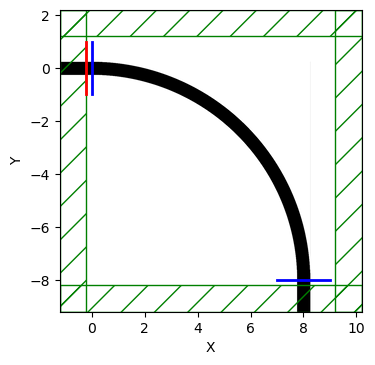

In [7]:
# If there is a warning that reads "The specified user volume
# is larger than the simulation domain and has been truncated",
# It has to do with some numerical errors between python and meep.
# Ignore.

f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Looks pretty good. Simulations at the high enough resolution required to avoid spurious reflections in the bend are very slow! This can be sped up quite a bit by running the code in parallel from the terminal. Later, we will put this notebook's code into a script and run it in parallel.

## Step 4. Simulate FDTD and Animate results

More detailed meep documentation available [here](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#transmittance-spectrum-of-a-waveguide-bend).

In [8]:
# Set to true to compute animation (may take a lot of memory)
compute_animation = True

In [9]:
# Setup and run the simulation

# The following line defines a stopping condition depending on the square
# of the amplitude of the Ez field at the port 2.
print(f"Stop condition: decay to 0.1% of peak value in the last {2.0/df:.1f} time units.")
stop_condition = mp.stop_when_fields_decayed(2.0/df,mp.Ez,p2.center,1e-3)
if compute_animation:
    f = plt.figure(dpi=100)
    animate = mp.Animate2D(sim,mp.Ez,f=f,normalize=True)
    sim.run(mp.at_every(1,animate), until_after_sources=stop_condition)
    plt.close()
    # Save video as mp4
    animate.to_mp4(10, 'media/bend.mp4')
else:
    sim.run(until_after_sources=stop_condition)

Stop condition: decay to 0.1% of peak value in the last 15.5 time units.
on time step 200 (time=1), 0.0383541 s/step
on time step 477 (time=2.385), 0.0144558 s/step
on time step 755 (time=3.775), 0.0144323 s/step
on time step 1029 (time=5.145), 0.0146304 s/step
on time step 1306 (time=6.53), 0.0144882 s/step
on time step 1583 (time=7.915), 0.0144634 s/step
on time step 1857 (time=9.285), 0.0146198 s/step
on time step 2135 (time=10.675), 0.0144386 s/step
on time step 2409 (time=12.045), 0.0146068 s/step
on time step 2687 (time=13.435), 0.0144364 s/step
on time step 2965 (time=14.825), 0.0144058 s/step
field decay(t = 15.505): 1.0968531133594091e-76 / 1.0968531133594091e-76 = 1.0
on time step 3239 (time=16.195), 0.0146098 s/step
on time step 3517 (time=17.585), 0.0143887 s/step
on time step 3796 (time=18.98), 0.0143683 s/step
on time step 4071 (time=20.355), 0.0145537 s/step
on time step 4350 (time=21.75), 0.0143623 s/step
on time step 4625 (time=23.125), 0.0145803 s/step
on time step 49

### Visualize results

Things to check:
- Was the simulation time long enough for the pulse to travel through port2 in its entirety? Given the automatic stop condition, this should be the case.

In [10]:
from IPython.display import Video, display
display(Video('media/bend.mp4'))

## Step 5. Compute loss and reflection of the bend

In [11]:
# Every mode monitor measures the power flowing through it in either the forward or backward direction
eig_mode1 = sim.get_eigenmode_coefficients(mode1, [1], eig_parity=mp.NO_PARITY)
eig_mode2 = sim.get_eigenmode_coefficients(mode2, [1], eig_parity=mp.NO_PARITY)

# First, we need to figure out which direction the "dominant planewave" k-vector is
# We can pick the first frequency (0) for that, assuming that for all simulated frequencies,
# The dominant k-vector will point in the same direction.
k1 = eig_mode1.kdom[0]
k2 = eig_mode2.kdom[0]

# eig_mode.alpha[0,0,0] corresponds to the forward direction, whereas
# eig_mode.alpha[0,0,1] corresponds to the backward direction

# For port 1, we are interested in the +x direction, so if k1.x is positive, select 0, otherwise 1
idx = (k1.x < 0) * 1
p1_thru_coeff = eig_mode1.alpha[0,:,idx]
p1_reflected_coeff = eig_mode1.alpha[0,:,1-idx]

# For port 2, we are interestred in the -y direction
idx = (k2.y > 0) * 1
p2_thru_coeff = eig_mode2.alpha[0,:,idx]
p2_reflected_coeff = eig_mode2.alpha[0,:,1-idx]

# transmittance
p2_trans = abs(p2_thru_coeff/p1_thru_coeff)**2
p2_reflected = abs(p1_reflected_coeff/p1_thru_coeff)**2

print("----------------------------------")
print(f"Parameters: radius={ring_radius:.1f}")
print(f"Frequencies: {mode1_freqs}")
print(f"Transmitted fraction: {p2_trans}")
print(f"Reflected fraction: {p2_reflected}")

MPB solved for omega_1(2.01141,0,0) = 0.618698 after 34 iters
MPB solved for omega_1(1.87532,0,0) = 0.580676 after 10 iters
MPB solved for omega_1(1.87521,0,0) = 0.580645 after 4 iters
MPB solved for omega_1(1.87521,0,0) = 0.580645 after 1 iters
Dominant planewave for band 1: (1.875210,-0.000000,0.000000)
MPB solved for omega_1(2.03004,0,0) = 0.623906 after 34 iters
MPB solved for omega_1(1.89458,0,0) = 0.586052 after 10 iters
MPB solved for omega_1(1.89447,0,0) = 0.586022 after 4 iters
MPB solved for omega_1(1.89447,0,0) = 0.586022 after 1 iters
Dominant planewave for band 1: (1.894467,-0.000000,0.000000)
MPB solved for omega_1(2.04866,0,0) = 0.629115 after 24 iters
MPB solved for omega_1(1.91383,0,0) = 0.591428 after 10 iters
MPB solved for omega_1(1.91372,0,0) = 0.591398 after 4 iters
MPB solved for omega_1(1.91372,0,0) = 0.591398 after 1 iters
Dominant planewave for band 1: (1.913720,-0.000000,0.000000)
MPB solved for omega_1(2.06729,0,0) = 0.634325 after 27 iters
MPB solved for om

Dominant planewave for band 1: (0.000000,1.894467,0.000000)
MPB solved for omega_1(0,2.04866,0) = 0.629115 after 27 iters
MPB solved for omega_1(0,1.91383,0) = 0.591428 after 7 iters
MPB solved for omega_1(0,1.91372,0) = 0.591398 after 3 iters
MPB solved for omega_1(0,1.91372,0) = 0.591398 after 1 iters
Dominant planewave for band 1: (0.000000,1.913720,0.000000)
MPB solved for omega_1(0,2.06729,0) = 0.634325 after 24 iters
MPB solved for omega_1(0,1.93307,0) = 0.596804 after 7 iters
MPB solved for omega_1(0,1.93297,0) = 0.596774 after 3 iters
MPB solved for omega_1(0,1.93297,0) = 0.596774 after 1 iters
Dominant planewave for band 1: (0.000000,1.932968,0.000000)
MPB solved for omega_1(0,2.08591,0) = 0.639536 after 29 iters
MPB solved for omega_1(0,1.95232,0) = 0.60218 after 7 iters
MPB solved for omega_1(0,1.95221,0) = 0.602151 after 3 iters
MPB solved for omega_1(0,1.95221,0) = 0.602151 after 1 iters
Dominant planewave for band 1: (0.000000,1.952212,0.000000)
MPB solved for omega_1(0,2

In [12]:
S21 = p2_thru_coeff/p1_thru_coeff
S11 = p1_reflected_coeff/p1_thru_coeff

S21_mag = np.abs(S21)
S21_phase = np.unwrap(np.angle(S21))
S11_mag = np.abs(S11)
S11_phase = np.unwrap(np.angle(S11))

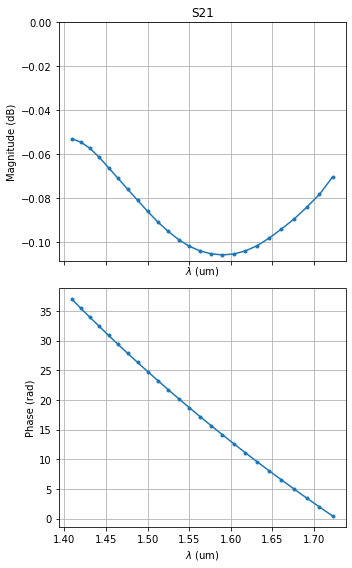

In [13]:
# Plot S21
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(S21_mag), '.-')
ax1.set_title("S21")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, S21_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()

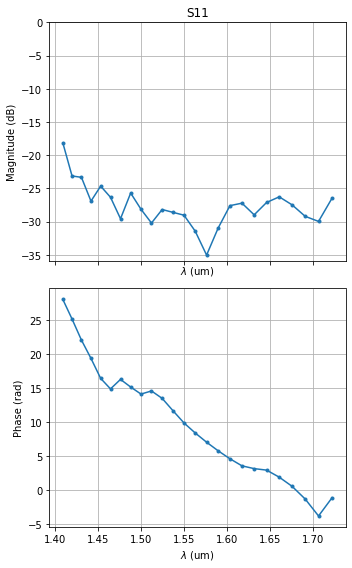

In [14]:
# Plot S11
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(S11_mag), '.-')
ax1.set_title("S11")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, S11_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()

# Milestones

Goal: Compute the transmission profile for bend radii between 1.5um and 10um. 

- Q: Is the reflection significant for any radius? What explain the loss?
- Q: What is the formula total size of the simulation region? How many pixels are there?
- Q: If each pixel can host 3-dimensional E-field and H-field vectors with 64bit complex float stored in each dimension, how many megabytes of data needs to be stored at each time step? Is it feasible to save all this information throughout the FDTD simulation?
- Bonus: Collect the simulation runtime for each radius. How does it change with different radii?
- Bonus: At what resolution does the accuracy of the simulation start degrading? In other words, if halving the resolution only results in a 1% relative difference in the most important target metric, it is still a good resolution.

In [17]:
#Write to csv file
import csv
with open(f'sparams.r{ring_radius:.1f}um.csv', mode='w') as sparams_file:
    sparam_writer = csv.writer(sparams_file, delimiter=',')
    sparam_writer.writerow(['f(Hz)','real(S11)','imag(S11)','real(S21)','imag(S21)'])
    for i in range(len(mode1_freqs)):
        sparam_writer.writerow([mode1_freqs[i] * 3e14,
                                np.real(S11[i]),np.imag(S11[i]),
                                np.real(S21[i]),np.imag(S21[i])
                               ])

## Guide for automation

We have transcribed the code in every cell into a file called `bent_waveguide.py`, and we have added an argument parser to help you.

Simply call `python bent_waveguide -r 4.5`, for example, to run the computation with a radius of 4.5 um, outputting to a csv file called `sparams.r4.5um.csv` for further processing.

If MPI is activated, and you have enough processor cores, run it with `mpirun -np 4 python bent_waveguide -r 4.5` for a 4x speedup.